This notebook performs early fusion. Early fusion first combines LiDAR and camera data then performs object detection using YOLOv5.

In [7]:
import os
from glob import glob

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch

from kitti_utils import *

import pymap3d as pm
import folium

%matplotlib inline
plt.rcParams["figure.figsize"] = (20, 10)

In [8]:
# !pip install pymap3d folium

## Files

In [9]:
DATE = "2011_09_26"
ID = "0005"

DATA_PATH = f"../data/{DATE}/{DATE}_drive_{ID}_sync"

CAMERA_CALIB_FILE = f"../data/{DATE}/calib_cam_to_cam.txt"

VELO_CALIB_FILE = f"../data/{DATE}/calib_velo_to_cam.txt"

IMU_CALIB_FILE = f"../data/{DATE}/calib_imu_to_velo.txt"

## Setup

The `glob` function is used here to perform pattern matching on the files.

In [10]:
# get RGB camera data
left_image_paths = sorted(glob(os.path.join(DATA_PATH, 'image_02/data/*.png')))
right_image_paths = sorted(glob(os.path.join(DATA_PATH, 'image_03/data/*.png')))

# get LiDAR data
bin_paths = sorted(glob(os.path.join(DATA_PATH, 'velodyne_points/data/*.bin')))

# get GPS/IMU data
oxts_paths = sorted(glob(os.path.join(DATA_PATH, r'oxts/data**/*.txt')))

print(f"Number of left images: {len(left_image_paths)}")
print(f"Number of right images: {len(right_image_paths)}")
print(f"Number of LiDAR point clouds: {len(bin_paths)}")
print(f"Number of GPS/IMU frames: {len(oxts_paths)}")

Number of left images: 154
Number of right images: 154
Number of LiDAR point clouds: 154
Number of GPS/IMU frames: 154


## Load Camera Calibration Data


In [11]:
with open(CAMERA_CALIB_FILE,'r') as f:
    calib = f.readlines()

In [12]:
# get projection matrices (rectified left camera --> left camera (u,v,z))
P_rect2_cam2 = np.array([float(x) for x in calib[25].strip().split(' ')[1:]]).reshape((3,4))


# get rectified rotation matrices (left camera --> rectified left camera)
R_ref0_rect2 = np.array([float(x) for x in calib[24].strip().split(' ')[1:]]).reshape((3, 3,))

# add (0,0,0) translation and convert to homogeneous coordinates
R_ref0_rect2 = np.insert(R_ref0_rect2, 3, values=[0,0,0], axis=0)
R_ref0_rect2 = np.insert(R_ref0_rect2, 3, values=[0,0,0,1], axis=1)


# get rigid transformation from Camera 0 (ref) to Camera 2
R_2 = np.array([float(x) for x in calib[21].strip().split(' ')[1:]]).reshape((3,3))
t_2 = np.array([float(x) for x in calib[22].strip().split(' ')[1:]]).reshape((3,1))


# get cam0 to cam2 rigid body transformation in homogeneous coordinates
T_ref0_ref2 = np.insert(np.hstack((R_2, t_2)), 3, values=[0,0,0,1], axis=0)     

## Load LiDAR and GPS/IMU Calibration Data

In [13]:
T_velo_ref0 = get_rigid_transformation(VELO_CALIB_FILE)
T_imu_velo = get_rigid_transformation(IMU_CALIB_FILE)


# transform from velo (LiDAR) to left color camera (shape 3x4)
T_velo_cam2 = P_rect2_cam2 @ R_ref0_rect2 @ T_ref0_ref2 @ T_velo_ref0


# homogeneous transform from left color camera to velo (LiDAR) (shape: 4x4)
T_cam2_velo = np.linalg.inv(np.insert(T_velo_cam2, 3, values=[0,0,0,1], axis=0))


# transform from IMU to left color camera (shape 3x4)
T_imu_cam2 = T_velo_cam2 @ T_imu_velo


# homogeneous transform from left color camera to IMU (shape: 4x4)
T_cam2_imu = np.linalg.inv(np.insert(T_imu_cam2, 3, values=[0,0,0,1], axis=0)) 

## Load Model

In [8]:
!pip install -r yolov5/requirements.txt

In [9]:
model = torch.hub.load('ultralytics/yolov5', 'yolov5s')  # or yolov5m, yolov5l, yolov5x, custom

Using cache found in /Users/johnlu/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2024-4-26 Python-3.9.13 torch-1.12.1 CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


In [10]:
# set confidence and IOU thresholds
model.conf = 0.25  # confidence threshold (0-1), default: 0.25
model.iou = 0.25  # NMS IoU threshold (0-1), default: 0.45

## Detection

In [11]:
def get_uvz_centers(image, velo_uvz, bboxes, draw=True):
    ''' Obtains detected object centers projected to uvz camera coordinates. 
        Starts by associating LiDAR uvz coordinates to detected object centers,
        once a match is found, the coordiantes are transformed to the uvz
        camera reference and added to the bboxes array.

        NOTE: The image is modified in place so there is no need to return it.

        Inputs:
          image - input image for detection 
          velo_uvz - LiDAR coordinates projected to camera reference
          bboxes - xyxy bounding boxes form detections from yolov5 model output
          draw - (_Bool) draw measured depths on image
        Outputs:
          bboxes_out - modified array containing the object centers projected
                       to uvz image coordinates
        '''

    # unpack LiDAR camera coordinates
    u, v, z = velo_uvz

    # get new output
    bboxes_out = np.zeros((bboxes.shape[0], bboxes.shape[1] + 3))
    bboxes_out[:, :bboxes.shape[1]] = bboxes

    # iterate through all detected bounding boxes
    for i, bbox in enumerate(bboxes):
        pt1 = torch.round(bbox[0:2]).to(torch.int).numpy()
        pt2 = torch.round(bbox[2:4]).to(torch.int).numpy()

        # get center location of the object on the image
        obj_x_center = (pt1[1] + pt2[1]) / 2
        obj_y_center = (pt1[0] + pt2[0]) / 2

        # now get the closest LiDAR points to the center
        center_delta = np.abs(np.array((v, u)) 
                              - np.array([[obj_x_center, obj_y_center]]).T)
        
        # choose coordinate pair with the smallest L2 norm
        min_loc = np.argmin(np.linalg.norm(center_delta, axis=0))

        # get LiDAR location in image/camera space
        velo_depth = z[min_loc]; # LiDAR depth in camera space
        uvz_location = np.array([u[min_loc], v[min_loc], velo_depth])
        
        # add velo projections (u, v, z) to bboxes_out
        bboxes_out[i, -3:] = uvz_location

        # draw depth on image at center of each bounding box
        # This is depth as perceived by the camera
        if draw:
            object_center = (np.round(obj_y_center).astype(int), 
                             np.round(obj_x_center).astype(int))
            cv2.putText(image, 
                        '{0:.2f} m'.format(velo_depth), 
                        object_center, # top left
                        cv2.FONT_HERSHEY_SIMPLEX, 
                        0.5, # font scale
                        (255, 0, 0), 2, cv2.LINE_AA)    
            
    return bboxes_out


In [12]:
def get_detection_coordinates(image, bin_path, draw_boxes=True, draw_depth=True):
    ''' Obtains detections for the input image, along with the coordinates of 
        the detected object centers. The coordinate obtained are:
            - Camera with depth --> uvz 
            - LiDAR/velo --> xyz
            - GPS/IMU --> xyz
        Inputs:
            image - rgb image to run detection on
            bin_path - path to LiDAR bin file
        Output:
            bboxes - array of detected bounding boxes, confidences, classes,
            velo_uv - LiDAR points projected to camera uvz coordinate frame
            coordinates - array of all object center coordinates in the frames
                          listed above
        '''
    ## 1. compute detections in the left image
    detections = model(image)

    # draw boxes on image
    if draw_boxes:
        detections.show() 

    # get bounding box locations (x1,y1), (x2,y2) Prob, class
    bboxes = detections.xyxy[0].cpu() # remove from GPU

    # get LiDAR points and transform them to image/camera space
    velo_uvz = project_velobin2uvz(bin_path,
                                   T_velo_cam2, 
                                   image, 
                                   remove_plane=True)

    # get uvz centers for detected objects
    bboxes = get_uvz_centers(image, 
                             velo_uvz, 
                             bboxes, 
                             draw=draw_depth)

    return bboxes, velo_uvz

## Convert IMU to LLA

In [13]:
def imu2geodetic(x, y, z, lat0, lon0, alt0, heading0):
    ''' Converts cartesian IMU coordinates to Geodetic based on current 
        location. This function works with x,y,z as vectors and lat0, lon0, 
        alt0 as scalars.

        - Correct orientation is provided by the heading
        - The Elevation must be corrected for pymap3d (i.e. 180 is 0 elevation)
        Inputs:
            x - IMU x-coodinate (either scaler of (Nx1) array)
            y - IMU y-coodinate (either scaler of (Nx1) array)
            z - IMU z-coodinate (either scaler of (Nx1) array)
            lat0 - initial Latitude in degrees
            lon0 - initial Longitude in degrees
            alt0 - initial Ellipsoidal Altitude in meters
            heading0 - initial heading in radians (0 - East, positive CCW)
        Outputs:
            lla - (Nx3) numpy array of 
        '''
    # convert to RAE
    rng = np.sqrt(x**2 + y**2 + z**2)
    az = np.degrees(np.arctan2(y, x)) + np.degrees(heading0)
    el = np.degrees(np.arctan2(np.sqrt(x**2 + y**2), z)) + 90 
    
    # convert to geodetic
    lla = pm.aer2geodetic(az, el, rng, lat0, lon0, alt0)

    # convert to numpy array
    lla = np.vstack((lla[0], lla[1], lla[2])).T

    return lla

## Test Pipeline

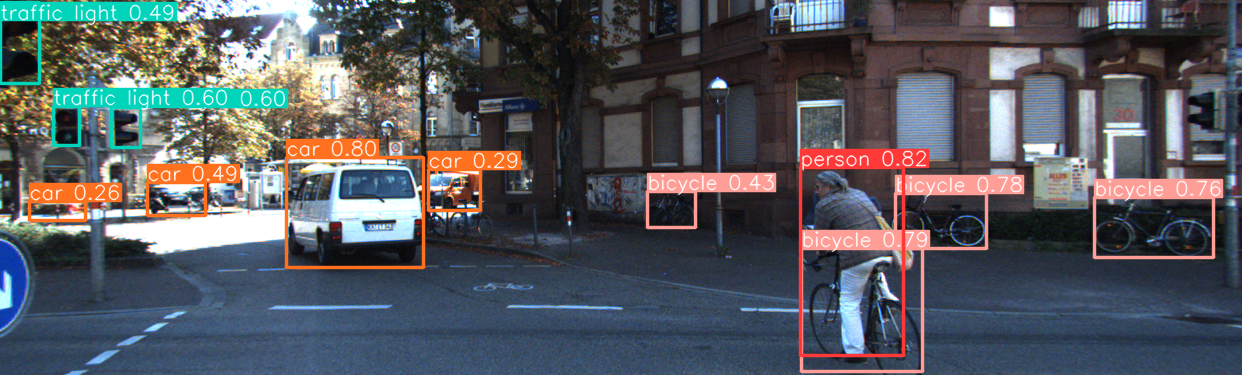

In [14]:
index = 10

left_image = cv2.cvtColor(cv2.imread(left_image_paths[index]), cv2.COLOR_BGR2RGB)
bin_path = bin_paths[index]
oxts_frame = get_oxts(oxts_paths[index])

# get detections and object centers in uvz
bboxes, velo_uvz = get_detection_coordinates(left_image, bin_path)

# get transformed coordinates of object centers
uvz = bboxes[:, -3:]

# transform to (u,v,z)
# velo_xyz = transform_uvz(uvz, T_cam2_velo) # we can also get LiDAR coordiantes
imu_xyz = transform_uvz(uvz, T_cam2_imu)

# get Lat/Lon on each detected object
lat0 = oxts_frame[0]
lon0 = oxts_frame[1]
alt0 = oxts_frame[2]
heading0 = oxts_frame[5]

lla = imu2geodetic(imu_xyz[:, 0], imu_xyz[:, 1], imu_xyz[:, 2], lat0, lon0, alt0, heading0)

In [15]:
left_image.shape

(375, 1242, 3)

In [16]:
velo_image = draw_velo_on_image(velo_uvz, np.zeros_like(left_image))

In [17]:
np.zeros_like(left_image).shape

(375, 1242, 3)

In [18]:
# stack image with LiDAR point cloud
stacked = np.vstack((left_image, velo_image))

# display stacked iamge
plt.imshow(stacked);

In [19]:
left_image_2 = cv2.cvtColor(cv2.imread(left_image_paths[index]), cv2.COLOR_BGR2RGB)
velo_image_2 = draw_velo_on_image(velo_uvz, left_image_2)

plt.imshow(velo_image_2);

## Map

In [20]:
def render_map(lat, lon):
    drive_map = folium.Map(
        location=(lat, lon), # starting location
        zoom_start=18
    )

    # add Lat/Lon points to map
    folium.CircleMarker(location=(lat, lon),
                        radius=2,
                        weight=5,
                        color='red').add_to(drive_map);

    # place the position of each detection on the map
    for pos in lla:
        folium.CircleMarker(location=(pos[0], pos[1]),
                            radius=2,
                            weight=5,
                            color='green').add_to(drive_map);

    # add Lat/Lon points to map
    folium.CircleMarker(location=(lat0, lon0),
                        radius=2,
                        weight=5,
                        color='red').add_to(drive_map);

    return drive_map

In [21]:
oxts_frame_ = get_oxts(oxts_paths[0])

lat, lon = oxts_frame[:2]

drive_map = render_map(lat, lon)

drive_map

## Scenario Drawing

In [22]:
canvas_height = stacked.shape[0]
canvas_width = 500

# get consistent center for ego vehicle
ego_center = (250, int(canvas_height*0.95))

# get rectangle coordiantes for ego vehicle
ego_x1 = ego_center[0] - 5
ego_y1 = ego_center[1] - 10
ego_x2 = ego_center[0] + 5
ego_y2 = ego_center[1] + 10

def draw_scenario(canvas, imu_xyz, sf=12):
    # draw ego vehicle
    cv2.rectangle(canvas, (ego_x1, ego_y1), (ego_x2, ego_y2), (0, 255, 0), -1);

    # draw detected objects
    for val in imu_xyz:
        obj_center = (ego_center[0] - sf*int(np.round(val[1])),
                      ego_center[1] - sf*int(np.round(val[0])))
        # cv2.circle(canvas, obj_center, 5, (255, 0, 0), -1);

        # get object rectangle coordinates
        obj_x1 = obj_center[0] - 5
        obj_y1 = obj_center[1] - 10
        obj_x2 = obj_center[0] + 5
        obj_y2 = obj_center[1] + 10

        cv2.rectangle(canvas, (obj_x1, obj_y1), (obj_x2, obj_y2), (255, 0, 0), -1);


    return canvas

In [23]:
canvas = np.zeros((canvas_height, canvas_width, 3), dtype=np.uint8)
draw_scenario(canvas, imu_xyz, sf=12)
plt.imshow(canvas);

In [24]:
frame = np.hstack((stacked, 
                  255*np.ones((canvas_height, 1, 3), dtype=np.uint8),
                  canvas))

plt.imshow(frame);

## Video

In [25]:
get_total_seconds = lambda hms: hms[0]*60*60 + hms[1]*60 + hms[2]


def timestamps2seconds(timestamp_path):
    ''' Reads in timestamp path and returns total seconds (does not account for day rollover '''
    timestamps = pd.read_csv(timestamp_path, 
                             header=None, 
                             squeeze=True).astype(object) \
                                          .apply(lambda x: x.split(' ')[1]) 
    
    # Get hours, minutes, and seconds
    hours = timestamps.apply(lambda x: x.split(':')[0]).astype(np.float64)
    minutes = timestamps.apply(lambda x: x.split(':')[1]).astype(np.float64)
    seconds = timestamps.apply(lambda x: x.split(':')[2]).astype(np.float64)

    hms_vals = np.vstack((hours, minutes, seconds)).T
    
    total_seconds = np.array(list(map(get_total_seconds, hms_vals)))
    
    return total_seconds

In [26]:
cam2_total_seconds = timestamps2seconds(os.path.join(DATA_PATH, r'image_02/timestamps.txt'))

/var/folders/kb/75nzr_1n56s5_rw0zrhwqhp00000gn/T/ipykernel_8289/3942237200.py:6: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  timestamps = pd.read_csv(timestamp_path,


In [27]:
# camera 2 frames per second
cam2_fps = 1/np.median(np.diff(cam2_total_seconds))
cam2_fps

9.68456518956033

In [28]:
ITERS = 150

In [29]:
result_video = []

# for index in range(len(left_image_paths)):
for index in range(ITERS):
    left_image = cv2.cvtColor(cv2.imread(left_image_paths[index]), cv2.COLOR_BGR2RGB)
    bin_path = bin_paths[index]
    oxts_frame = get_oxts(oxts_paths[index])

    # get detections and object centers in uvz
    bboxes, velo_uvz = get_detection_coordinates(left_image, bin_path, False)

    # get transformed coordinates
    uvz = bboxes[:, -3:]

    # velo_xyz = transform_uvz(uvz, T_cam2_velo) # we can also get LiDAR coordiantes
    imu_xyz = transform_uvz(uvz, T_cam2_imu)

    # draw velo on blank image
    velo_image = draw_velo_on_image(velo_uvz, np.zeros_like(left_image))

    # stack frames
    stacked = np.vstack((left_image, velo_image))

    # draw top down scenario on canvas
    canvas = np.zeros((canvas_height, canvas_width, 3), dtype=np.uint8)
    draw_scenario(canvas, imu_xyz, sf=12)
    
    # place everything in a single frame
    frame = np.hstack((stacked, 
                       255*np.ones((canvas_height, 1, 3), dtype=np.uint8),
                       canvas))

    # add to result video
    result_video.append(frame)

# get width and height for video frames
h, w, _ = frame.shape

KeyboardInterrupt: 

In [ ]:
out = cv2.VideoWriter(f'lidar_frame_stack_{DATE}.mp4',
                      cv2.VideoWriter_fourcc(*'MP4V'), 
                      cam2_fps, 
                      (w,h))
 
for i in range(len(result_video)):
    out.write(cv2.cvtColor(result_video[i], cv2.COLOR_BGR2RGB))
out.release()     